In [1]:
import os 
import cv2
import pafy
import math, random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from pytube import YouTube

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split
from keras.layers import *
from keras.models import Sequential
from keras.utils import to_categorical, plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

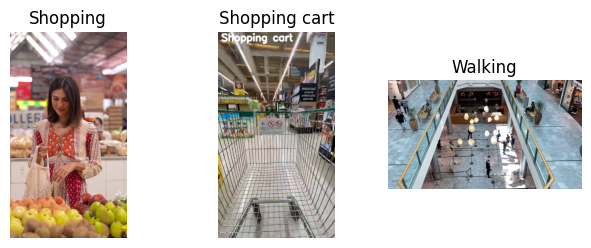

In [3]:
# Names of the categories
all_classes_names = os.listdir('data')

num_cols = 3  # Number of columns in the grid
num_rows = (len(all_classes_names) // num_cols) + 1  # Number of rows

for i, name in enumerate(all_classes_names):
    list_of_videos = os.listdir(f'data/{name}')
    selected_video = random.choice(list_of_videos)
    video_reader = cv2.VideoCapture(f"data/{name}/{selected_video}")
    
    # Read first frame
    _, bgr_frame = video_reader.read()
    # Release the VideoCapture
    video_reader.release()
    
    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 4, cv2.LINE_AA)
    
    # Display the frame.
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(rgb_frame)
    plt.title(name)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "data"

CLASSES_LIST = os.listdir(DATASET_DIR)

In [5]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

In [6]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [7]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Shopping


Extracting Data of Class: Shopping cart
Extracting Data of Class: Walking


In [8]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [9]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [10]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [11]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 20, 64, 64, 16)    448       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 20, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 20, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 16, 16, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 20, 4, 4, 32)      0

In [12]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure.png', show_shapes = True, show_layer_names = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [13]:
# Compile the dense neural network model
LRCN_model.compile(
    optimizer="adam",
    loss= "categorical_crossentropy",
    metrics=['accuracy']
)

In [16]:
# Creating a EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min')

# Defining the path for saving checkpoints
checkpoint_filepath = 'lrcn_model.h5'

# Create a ModelCheckpoint callback to save the best model weights
model_checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_loss',  
    save_best_only=True, 
    mode='min',  
    verbose=1  
)

LRCN_model_training_history = LRCN_model.fit(features_train, 
                                            labels_train, 
                                            epochs=150, 
                                            shuffle=True, 
                                            validation_split=0.1, 
                                            callbacks=[early_stopping, model_checkpoint])

Epoch 1/150
1/1 [==============================] - ETA: 0s - loss: 0.5249 - accuracy: 0.8750
Epoch 1: val_loss improved from inf to 0.66367, saving model to lrcn_model.h5
1/1 [==============================] - 1s 570ms/step - loss: 0.5249 - accuracy: 0.8750 - val_loss: 0.6637 - val_accuracy: 1.0000
Epoch 2/150
1/1 [==============================] - ETA: 0s - loss: 0.4266 - accuracy: 0.8750
Epoch 2: val_loss improved from 0.66367 to 0.42298, saving model to lrcn_model.h5
1/1 [==============================] - 0s 470ms/step - loss: 0.4266 - accuracy: 0.8750 - val_loss: 0.4230 - val_accuracy: 1.0000
Epoch 3/150
1/1 [==============================] - ETA: 0s - loss: 0.3615 - accuracy: 1.0000
Epoch 3: val_loss improved from 0.42298 to 0.28811, saving model to lrcn_model.h5
1/1 [==============================] - 1s 632ms/step - loss: 0.3615 - accuracy: 1.0000 - val_loss: 0.2881 - val_accuracy: 1.0000
Epoch 4/150
1/1 [==============================] - ETA: 0s - loss: 0.4423 - accuracy: 0.7500

In [27]:
def plot_metric(model, metric1, metric2, title):
    # Extract training and validation loss values from the model's history
    metric_value_1 = model.history[metric1]
    metric_value_2 = model.history[metric2]

    # Plot the training loss and validation loss
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(metric_value_1, label=f'{metric1}')
    ax.plot(metric_value_2, label=f'{metric2}')

    # Adding titles and labels to the plot
    ax.set_title(title) 
    ax.set_xlabel('Epoch')
    ax.set_ylabel(metric1)

    # Add a grid to the plot for better visualization
    ax.grid()

    # Add a legend to distinguish between training and validation loss
    ax.legend()
    plt.show()

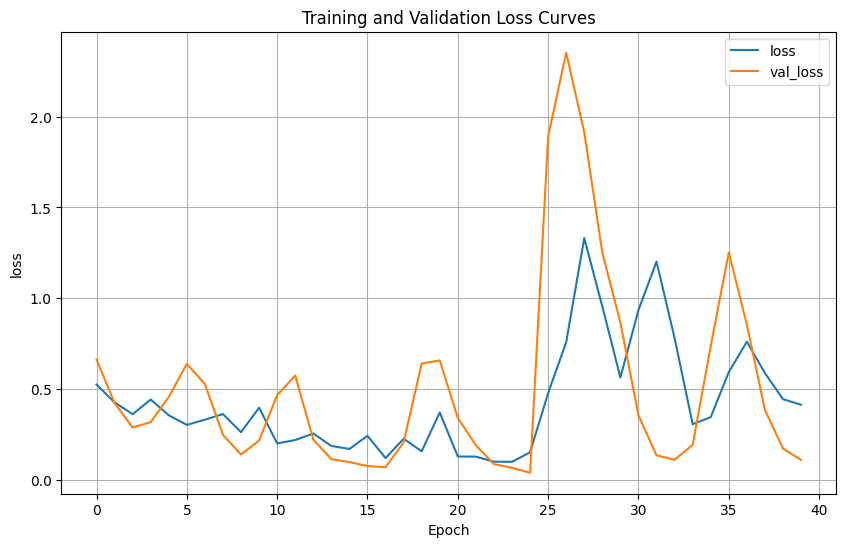

In [28]:
plot_metric(LRCN_model_training_history, 'loss',  'val_loss', 'Training and Validation Loss Curves')

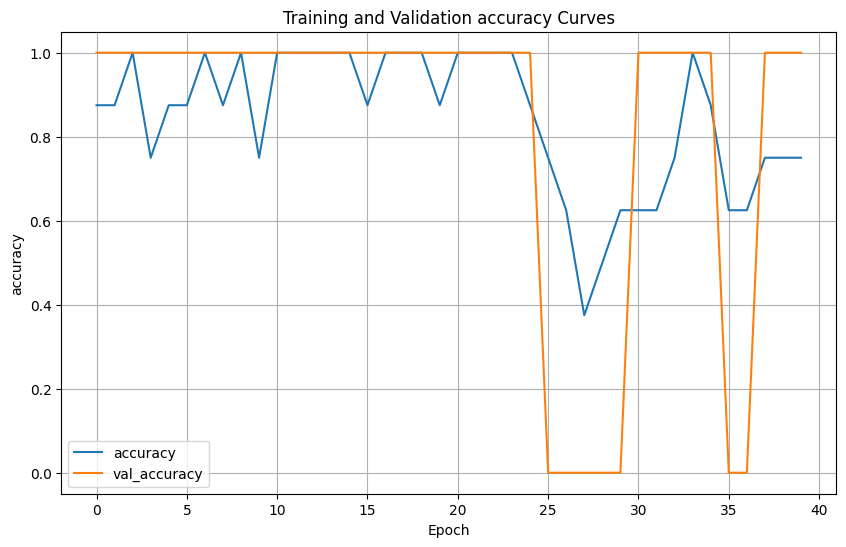

In [29]:
plot_metric(LRCN_model_training_history, 'accuracy',  'val_accuracy', 'Training and Validation accuracy Curves')

In [32]:
# Load the saved model weights
LRCN_model.load_weights('lrcn_model.h5')

# Evaluate the model on the test data
test_loss, test_accuracy = LRCN_model.evaluate(features_test, labels_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1/1 [==============================] - 0s 87ms/step - loss: 1.0933 - accuracy: 0.6667
Test Loss: 1.0933218002319336
Test Accuracy: 0.6666666865348816


In [44]:
def download_youtube_videos(youtube_video_url, output_directory):
    try:
        yt = YouTube(youtube_video_url)
        title = yt.title
        stream = yt.streams.get_highest_resolution()
        stream.download(output_directory)
        return title
    except Exception as e:
        print(f"Error occurred: {e}")
        return None

In [47]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read() 
        
        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(normalized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = CLASSES_LIST[predicted_label]

        # Write predicted class name on top of the frame.
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)
        
    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [43]:
# Example usage:
video_url = 'https://www.youtube.com/watch?v=_bmSDYqO8Dw'
output_directory = 'test_videos'

# Download the YouTube video
video_title = download_youtube_videos(video_url, output_directory)

if video_title:
    print(f"Video '{video_title}' downloaded successfully.")
    input_video_file_path = f'{output_directory}/{video_title}.mp4'
    output_video_file_path = f'{output_directory}/{video_title}-Output-SeqLen{SEQUENCE_LENGTH}.mp4'
    
    # Perform Action Recognition on the Test Video
    predict_on_video(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)
    
    # Display the output video
    try:
        video_clip = VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()
    except Exception as e:
        print(f"Error displaying video: {e}")

Video 'People Walking Inside Shopping Mall Stock Footage' downloaded successfully.
1/1 [==============================] - 0s 32ms/step
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
